# Temporal Link Prediction Using Tensor Factorization

## Import Libraries

In [21]:
import pandas as pd
import glob
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorly.decomposition import parafac
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
# from statsmodels.tsa.api import SimpleExpSmoothing

## Read in Data

In [2]:
cols = ['Year', 'Reporter Code', 'Reporter', 'Partner Code', 'Partner', 'Trade Value (US$)']
schema = {'Year': str, 'Reporter Code': str, 'Partner Code': str}
def dfs():
    for file in glob.glob('data/*.csv'):
        yield pd.read_csv(file, encoding='latin-1', usecols=cols, 
                          dtype=schema)
df = pd.concat(dfs())
df.dropna(inplace=True)
df.rename(columns={'Reporter Code': 'Reporter_Code', 'Partner Code': 'Partner_Code', 'Trade Value (US$)': 'Trade_Value'}, inplace=True)

In [3]:
reporters = set(df.Reporter_Code.unique())
print(len(reporters), "Source nodes are present. (Some have invalid data so dropped)")
df_ = df[df.Partner_Code.isin(reporters)]  #induced sub-graph creation
print("Filtered records from", len(df), "to", len(df_))

143 Source nodes are present. (Some have invalid data so dropped)
Filtered records from 74077 to 66316


In [4]:
# Filtered DF is essentially an induced graph now
# Uncomment to save file
#df_.to_csv('filtered_df.csv', header=True)

In [5]:
# Get countries and their index
countries = df_.Reporter.unique()
country_to_index = dict(zip(countries, range(len(countries))))
index_to_country = dict(map(reversed, country_to_index.items()));

## Create tensors

In [6]:
# We can now start creating tensors
# First dimension is for time (10 years)
# Second dimension is for TO
N = len(countries)
tensor = np.zeros((10, N, N))

In [7]:
# Create tensors for each year
for i, year in enumerate(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']):
    # Data of that particular year
    df__ = df_[df_.Year == year]
    # For the scale of this data, I think we can just iterate over it.
    for _, row in df__.iterrows():
        country_from = row['Partner']
        country_to = row['Reporter']
        tensor[i, country_to_index[country_from], country_to_index[country_to]] = row['Trade_Value']

In [8]:
# How much of the tensor is sparse?
sparsity = 1.0 - np.count_nonzero(tensor) / tensor.size
print(f"{sparsity*100:.2f}% of the tensor is sparse")

67.58% of the tensor is sparse


In [9]:
# Normalizing our tensor. For the first version, let's just calculate the log
non_zeros = (tensor!=0)
tensor[non_zeros] = np.log(tensor[non_zeros])

## Tensor Factorization

In [10]:
# Can tinker with ranks
# Mask has a special significance, we should really discuss and explore more about it
weights, factors = parafac(tensor, rank=150, normalize_factors=True, mask=non_zeros, random_state=42)


In [11]:
# get one slice of the tensor
def get_slice(A, B, T, W, suppress_output=False):
    # Given the two matrices, get the slice
    if not suppress_output:
        print("Shape of A", A.shape)
        print("Shape of B", B.shape)
        print("Shape of T", T.shape)
        print("Shape of W", W.shape)
        print ("Shape of np.diag(W*T)", np.diag(W*T).shape)
    return np.matmul(np.matmul(A, np.diag(W*T)), B.T)

sl = get_slice(factors[1], factors[2], factors[0][9], weights)
sl[non_zeros[9]]

Shape of A (143, 150)
Shape of B (143, 150)
Shape of T (150,)
Shape of W (150,)
Shape of np.diag(W*T) (150, 150)


array([ 5.85512649, 12.46666417, 18.52192549, ..., 14.76686959,
       15.63305322, 17.11343875])

In [12]:
# recursive implementation of exponential smoothing
# Input: list of vectors, alpha
# Output: Next vector
def exponential_smoothing_recursive(vectors, alpha, depth=-1):
    if depth==-1:                          # -1 means the last one
        depth = len(vectors)-1
    if depth == 0:                        # For the first vector, return as is.
        return vectors[0]
    return alpha * vectors[depth] + \
            (1-alpha) * exponential_smoothing_recursive(vectors, alpha, depth-1)

exponential_smoothing_recursive([1,2,3], .5)

2.25

In [13]:
# Get an example forecast
next_C = exponential_smoothing_recursive(factors[0], alpha=0.5)
forecast = get_slice(factors[1], factors[2], next_C, weights)

Shape of A (143, 150)
Shape of B (143, 150)
Shape of T (150,)
Shape of W (150,)
Shape of np.diag(W*T) (150, 150)


In [14]:
# test for slice at year 2019
slice_2019 = get_slice(factors[1], factors[2], factors[0][7], weights)

Shape of A (143, 150)
Shape of B (143, 150)
Shape of T (150,)
Shape of W (150,)
Shape of np.diag(W*T) (150, 150)


## Experimentation

In [15]:
def RMSE(actual, pred):     
    return (mean_squared_error(actual,pred))**0.5

In [16]:
# define experiment that loops through values of alpha
def alpha_experiment(num_years):
    rmse = []
    for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        C = exponential_smoothing_recursive(factors[0][0:num_years], alpha = alpha)
        forecast = get_slice(factors[1], factors[2], C, weights, suppress_output=True)
        rmse.append(RMSE(slice_2019, forecast))
        
    return rmse

In [17]:
# Run experiments for different number of years included in prediction and different values for alpha
experiments = []
for i in range(1, 8):
    experiments.append(alpha_experiment(i))
    
experiments

[[7.9232881577398615,
  7.9232881577398615,
  7.9232881577398615,
  7.9232881577398615,
  7.9232881577398615,
  7.9232881577398615,
  7.9232881577398615,
  7.9232881577398615,
  7.9232881577398615,
  7.9232881577398615],
 [7.623025531190928,
  7.361509722052515,
  7.14299773530943,
  6.971534409688772,
  6.850653364781381,
  6.783059423548,
  6.770348800649281,
  6.812828688701924,
  6.909481219369783,
  7.058081242102878],
 [7.298189608274014,
  6.847697055379872,
  6.557019955559121,
  6.402969476263094,
  6.35729271430437,
  6.391367291918184,
  6.480336053119316,
  6.605614648620121,
  6.755819288286121,
  6.926677947412208],
 [6.969955104764222,
  6.376148494002814,
  6.055861918772057,
  5.92090054397157,
  5.898967821489927,
  5.941492293453789,
  6.021485927021099,
  6.127214784051347,
  6.25598575423602,
  6.409794521981719],
 [6.611541086362098,
  5.904391862904516,
  5.589243103987273,
  5.488338328025537,
  5.488023197440405,
  5.529252803931952,
  5.585667984432773,
  5.64

In [18]:
# The best RMSE values are those using all years for prediction
preds_all_years = experiments[-1]
preds_all_years

[5.780328855597892,
 4.717522033512287,
 4.213490822019018,
 3.9720804652145167,
 3.8617856536043393,
 3.8268002305384714,
 3.838049932307209,
 3.876712383369916,
 3.930305180139127,
 3.991582426186814]

In [19]:
# The optimum alpha value is 0.6
preds_all_years[5]

3.8268002305384714

Text(0, 0.5, 'RMSE')

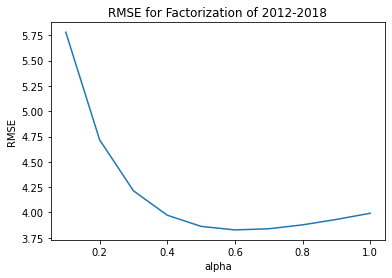

In [29]:
# Plots
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.plot(alphas, preds_all_years)
plt.title("RMSE for Factorization of 2012-2018")
plt.xlabel("alpha")
plt.ylabel("RMSE")

Text(0, 0.5, 'RMSE')

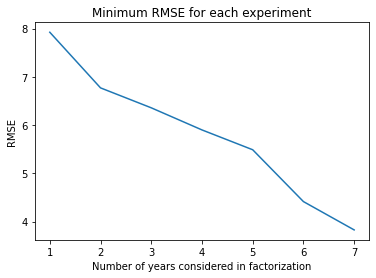

In [34]:
# Plot the best RMSE for each run of the experiment
best_runs = [min(rmse) for rmse in experiments]
num_years = [num for num in range(1,8)]
plt.plot(num_years, best_runs)
plt.title("Minimum RMSE for each experiment")
plt.xlabel("Number of years considered in factorization")
plt.ylabel("RMSE")

In [38]:
slice_2020 = get_slice(factors[1], factors[2], factors[0][8], weights)
slice_2021 = get_slice(factors[1], factors[2], factors[0][9], weights)

Shape of A (143, 150)
Shape of B (143, 150)
Shape of T (150,)
Shape of W (150,)
Shape of np.diag(W*T) (150, 150)
Shape of A (143, 150)
Shape of B (143, 150)
Shape of T (150,)
Shape of W (150,)
Shape of np.diag(W*T) (150, 150)


In [39]:
# define a function that predicts for a specific year (ie 2020 and 2021)
def predict_year(num_years, slice_year):
    rmse = []
    for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        C = exponential_smoothing_recursive(factors[0][0:num_years], alpha = alpha)
        forecast = get_slice(factors[1], factors[2], C, weights, suppress_output=True)
        rmse.append(RMSE(slice_year, forecast))
        
    return rmse

In [42]:
# does it predict well on 2020/2021?
prediction_2020 = []
for i in range(8, 9):
    prediction_2020.append(predict_year(i, slice_2020))
prediction_2020

[[5.798378250277405,
  4.735217542109554,
  4.288174138159562,
  4.089822157079424,
  3.9939272792272438,
  3.9428643851677094,
  3.912879044925871,
  3.896145724878991,
  3.8935441264302395,
  3.9104632810122357]]

In [43]:
prediction_2021 = []
for i in range(8, 10):
    prediction_2021.append(predict_year(i, slice_2021))
prediction_2021

[[11.4852899380621,
  11.12366484941069,
  11.051707310653228,
  11.065451625578056,
  11.102831081610923,
  11.144999815841143,
  11.186918022866752,
  11.228997317172658,
  11.274125830854643,
  11.326188585940034],
 [11.329847707526456,
  10.988288747538533,
  10.938398945713391,
  10.96060107396161,
  11.000084724131435,
  11.044332651039666,
  11.091597176715275,
  11.142466595529044,
  11.19741743715494,
  11.256402507250334]]

Text(0, 0.5, 'RMSE')

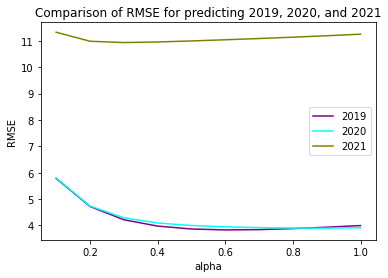

In [57]:
plt.plot(alphas, preds_all_years, color="purple")
plt.plot(alphas, prediction_2020[-1], color="cyan")
plt.plot(alphas, prediction_2021[-1], color="olive")


plt.title("Comparison of RMSE for predicting 2019, 2020, and 2021")
plt.legend(["2019","2020", "2021"])
plt.xlabel("alpha")
plt.ylabel("RMSE")

Text(0, 0.5, 'RMSE')

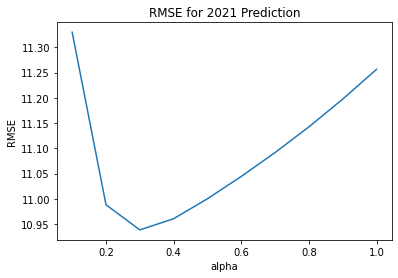

In [58]:
# Take a closer look at 2021
plt.plot(alphas, prediction_2021[-1])

plt.title("RMSE for 2021 Prediction")
plt.xlabel("alpha")
plt.ylabel("RMSE")